In [2]:
import pandas as pd
import scipy.stats as st
from tqdm import tqdm
import seaborn as sns 
import matplotlib.pyplot as plt
import pandahouse as ph
import numpy as np

In [2]:
#                                                   Задание 1

In [3]:
groups_df = pd.read_csv(r'/home/jupyter-i.gorodnichev-15/files_for_project/Проект_2_groups.csv', sep=';',
                        encoding='utf-8') 
# судя по всему, файлы неправильно были сохранены в csv формат, из-за чего некоторые строки не считываются корректно,
# т.к. при их просмотре в  текстовом редакторе каких-либо ошибок не видно. Можно пересохранить их или игнорировать 
# строки, вызывающие ошибку (параметр error_bad_lines метода read_csv должен быть равен False).

info_df = pd.read_csv(r'/home/jupyter-i.gorodnichev-15/files_for_project/Проект_2_active_studs.csv', sep=';',
                      encoding='utf-8')

cheks_df = pd.read_csv(r'/home/jupyter-i.gorodnichev-15/files_for_project/Проект_2_checks.csv', sep=';',
                       encoding='utf-8')

In [57]:
# проверим данные на предмет пустых значений 
groups_df.isna().sum()

id     0
grp    0
dtype: int64

In [58]:
info_df.isna().sum()

student_id    0
dtype: int64

In [59]:
cheks_df.isna().sum()

student_id    0
rev           0
dtype: int64

In [60]:
# посмотрим, есть ли повторные покупки у одного и того же пользователя
# это позволит говорить о независимости выборок при делении на группы
cheks_df[cheks_df['student_id'].duplicated() == True].sum()

student_id    0.0
rev           0.0
dtype: float64

In [61]:
# Проверим, как разделились активные пользователи по группам
active_gr = groups_df.merge(right=info_df, how='inner', left_on='id', right_on='student_id')
active_gr['grp'].value_counts()

B    6793
A    1535
Name: grp, dtype: int64

In [62]:
# Посмотрим на изначальное распределение по группам
groups_df['grp'].value_counts()

B    59813
A    14671
Name: grp, dtype: int64

In [63]:
# Из этого распределения видно, что изначальное количество пользователей из группы Б
# примерно в 4 раза выше, чем число пользователей из группы А. Возможно была неправильно 
# настроена система сплитования.

In [64]:
# Посмотрим на распределение по группам платящих пользователей
groups_checks = groups_df.merge(right=cheks_df, how='inner', left_on='id', right_on='student_id')
groups_checks['grp'].value_counts()

B    433
A    107
Name: grp, dtype: int64

In [65]:
# Посмотрим на число активных платящих пользователей
checks_info = cheks_df.merge(right=info_df, how='inner', on='student_id')
checks_info.shape[0]

392

In [66]:
# на основе разницы количеств платящих пользователей и активных платящих, видно, что была группа пользователей, 
# которые заплатили, но не были отмечены, как активные. Либо они не были зарегистрированы, как активные,
# по ошибке, либо они решили приобрести какой-либо курс во время проведения эксперимента, но 
# не проявляли после его покупки активность. Можно провести АБ-тест и только для активных платящих 
# пользователей, и для них + платящих, что не были засчитаны как активные. 

In [67]:
# в качестве метрик, проверяемых АБ-тестом можно рассмотреть средний чек пользователя как показатель 
# того, сколько прибыли приносит та или иная группа, и конверсию.
# В данном случае средний чек - это среднее данных об оплате (столбец "rev"), т.к. один и тот же  
# пользователь не совершал повторных покупок, а число всех оплат и есть число чеков. 
# Конверсию также стоит рассмотреть, т.к. при даже при более низком ее значении средний чек 
# может быть выше из-за крупных покупок некоторых пользователей (это не обязательно будет зарегистрировано 
# как выброс), а само по себе понижение конверсииничем хорошим не является. 
# Помимо этого в количестве данных для групп А и Б наблюдается диспропорция, которая может 
# быть причиной искажения результатов.

In [68]:
# АБ-тест только для активных платящих 

In [113]:
# получим данные о чеках активных платящих во время теста пользователей, которые отнесены к какой-либо группе 
merged_checks = cheks_df.merge(right=info_df, how='inner', on='student_id')
    .merge(right=groups_df, how='inner', left_on='student_id', right_on='id') 
merged_checks = merged_checks.drop(columns='id')  # удалим лишнюю колонку 
group_A = merged_checks[merged_checks['grp'] == 'A'].reset_index(drop=True)  # переназначим index 
group_B = merged_checks[merged_checks['grp'] == 'B'].reset_index(drop=True)  # переназначим index

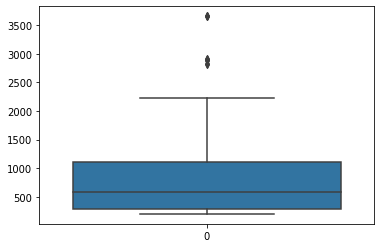

In [71]:
sns.boxplot(data=group_A['rev'])  # проверим данные об оплате на наличие выбросов

In [72]:
# имеются выбросы, что может исказить результаты Т-теста 

In [73]:
st.shapiro(x=group_A['rev'])  # проверка на нормальность распределения данных о платежах 
# распределение нельзя считать нормальным, поэтому для АА-теста лучше не использовать Т-тест 

ShapiroResult(statistic=0.7353236079216003, pvalue=1.4986822893803264e-10)

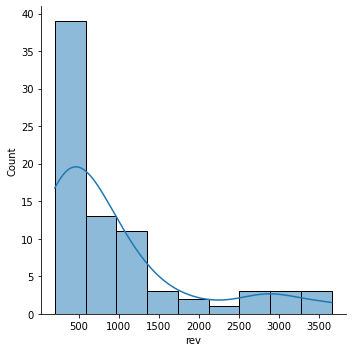

In [74]:
sns.displot(x=group_A['rev'], kde=True)  # распределение данных в группе А 

In [75]:
# Посмотрим на соответствие данных в выборке для группы Б нормальному распределению
st.shapiro(x=group_B['rev'])

ShapiroResult(statistic=0.8551987409591675, pvalue=1.756778758085431e-16)

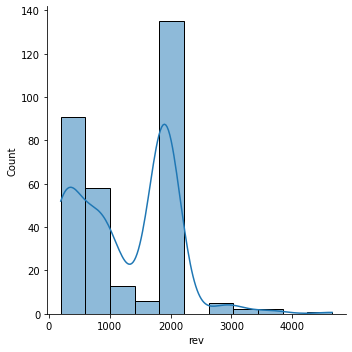

In [76]:
sns.displot(x=group_B['rev'], kde=True)  # распределение данных в группе Б
# по результатам теста и по графику видно, что распределение сильно отклоняется от нормального 

In [77]:
# распределения нельзя считать нормальными 
# предполагается использовать U-тест Манна-Уитни для двух независимых выборок (мы принимаем, что выборки такие, 
# т.к. выбранные значения не возвращаются в исходный массив данных, а повторных данных от одного пользователя 
# не поступало)

In [78]:
st.levene(group_A['rev'], group_B['rev'])  # проверка на гомогенность дисперсии 
# дисперсии можно признать равными 

LeveneResult(statistic=3.0558643506726035, pvalue=0.08123509393501775)

In [79]:
# проведем непараметрический тест Манна-Уитни для АБ-теста (выбран, т.к. распределение выборок 
# не соответствует нормальному). 
st.mannwhitneyu(group_A['rev'], group_B['rev'])

MannwhitneyuResult(statistic=8990.0, pvalue=0.000273244700505943)

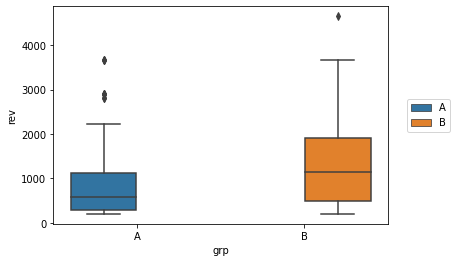

In [80]:
# Построим боксплот для наглядности 
ax = sns.boxplot(data=merged_checks, hue='grp', y='rev', x='grp')
plt.legend(loc='center right', bbox_to_anchor=(1.2, 0.5))  # переместим легенду для более удобного отображения 

In [83]:
# Согласно тесту Манна-Уитни группа А значимо отличается от группы Б, однако при визуализации 
# заметно, что в данных есть выбросы
# возможно стоит проверить, как они влияют на результат (хотя непараметрический тест не так 
# сильно подвержден влиянию выбросов) 

In [107]:
drops_B = group_B['rev'].sort_values(ascending=False).reset_index(drop=True)  # отсортируем значения и 
# переназначим индексы для более удобного поиска выбросов
drops_B.head(15)  # как видно из боксплота, для группы Б выбросом является значение, превышающее 4000, 
# в данных такое значение только одно - 4650

0     4650.0
1     3660.0
2     3660.0
3     3260.0
4     3040.0
5     2910.0
6     2910.0
7     2890.0
8     2890.0
9     2890.0
10    2220.0
11    2190.0
12    2099.0
13    2099.0
14    2099.0
Name: rev, dtype: float64

In [108]:
drops_B = drops_B.drop(index=0)  # удаляем выброс
drops_B

1      3660.0
2      3660.0
3      3260.0
4      3040.0
5      2910.0
        ...  
308     199.0
309     199.0
310     199.0
311     199.0
312     199.0
Name: rev, Length: 312, dtype: float64

In [109]:
drops_A = group_A['rev'].sort_values(ascending=False).reset_index(drop=True)  # отсортируем значения и 
# переназначим индексы для более удобного поиска и удаления выбросов
drops_A.head(15)  # судя по боксплоту для группы А выбросами являются значения, превышающие примерно 2300, 
# избавимся от них

0     3660.0
1     3660.0
2     3660.0
3     2910.0
4     2910.0
5     2900.0
6     2890.0
7     2820.0
8     2820.0
9     2220.0
10    1980.0
11    1830.0
12    1530.0
13    1530.0
14    1530.0
Name: rev, dtype: float64

In [110]:
drops_A = drops_A[drops_A < 2500]  # избавимся от выбросов 
drops_A

9     2220.0
10    1980.0
11    1830.0
12    1530.0
13    1530.0
       ...  
73     199.0
74     199.0
75     199.0
76     199.0
77     199.0
Name: rev, Length: 69, dtype: float64

In [111]:
st.mannwhitneyu(drops_B, drops_A)  # теперь посмотрим, как одновременное удаление выбросов из 
# групп А и Б влияет на результат 

MannwhitneyuResult(statistic=15301.5, pvalue=2.9795874499994477e-08)

In [ ]:
# После удаления выбросов из обеих групп результат теста все равно говорит о статистически значимых 
# различиях между группами при оценке среднего чека среди активных платящих пользователей.

In [ ]:
# теперь проведем тест для конверсии в покупку среди активных платящих пользователей.

In [8]:
# создадим столбец с отметкой о том, сконвертировался ли пользователь или нет
CR_active = info_df.merge(right=cheks_df, how='inner', on='student_id')
    .merge(right=groups_df, left_on='student_id', right_on='id', how='outer')
CR_active['is_converted'] = pd.cut(x=CR_active['rev'], bins=[-1, 0, max(CR_active['rev'])], labels=[0, 1])
    .fillna(0)
CR_active['is_converted'] = CR_active['is_converted'].astype('Int32')

In [9]:
# создадим две выборки для разных групп
CR_active_A = CR_active[CR_active['grp'] == 'A']
CR_active_B = CR_active[CR_active['grp'] == 'B']

In [102]:
# проверка на гомогенносить дисперсий
st.levene(CR_active_A['is_converted'], CR_active_B['is_converted'])

LeveneResult(statistic=0.015780755561465923, pvalue=0.9000319002273636)

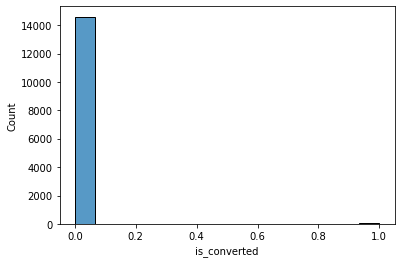

In [13]:
# посмотрим на распределение в выборках
sns.histplot(x=CR_active_A['is_converted'])

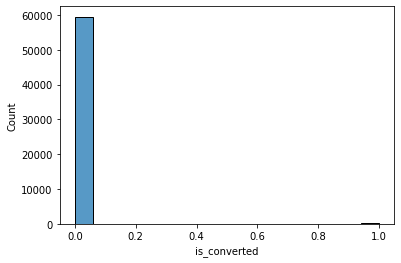

In [14]:
sns.histplot(x=CR_active_B['is_converted'])

In [128]:
# выборки независимы, т.к. взяты данные о разных пользователях, а они предположительно делились
# на группы случайно. Однако распределение у обоих выборок ненормальное (лишь значения 1 и 0),
# поэтому использовать параметрические тесты не стоит.
# Но для непараметрического теста Манна-Уитни нужно, чтобы в каждой выборке
# не было большого числа повторяющихся значений. У нас их всего два - 1 и 0. 
# Поэтому применим бутстрап, используя при этом в качестве меры центральной тенденции среднее,
# т.к. в данной ситуации нас интересует именно разность между мерацми центральной тенденции,
# а использование среднего будет более наглядно и чувствительно к различиям, т.к. при использовании 
# медианы или моды  разностью мер будут нули (т.к. нулей больше намного, чем единицц), соответственно 
# на графике распределения разностей мер тенденции мы увидим лишь ноль. 

In [10]:
def get_bootstrap(
    data_column_1,  # числовые значения первой выборки
    data_column_2,  # числовые значения второй выборки
    boot_it=1000,  # количество бутстрэп-подвыборок
    statistic=np.mean,  # интересующая нас статистика
    bootstrap_conf_level=0.95  # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)):  # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace=True  # возвращаем значения в выборку
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace=True
        ).values
        
        boot_data.append(statistic(samples_1) - statistic(samples_2))  # применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level) / 2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])  # доверительный интервал
     
    # Визуализация
    plt.hist(pd_boot_data[0], bins=50)
    
    plt.style.use('ggplot')
    plt.vlines(ci, ymin=0, ymax=50, linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, "ci": ci}

100%|██████████| 5000/5000 [05:22<00:00, 15.50it/s]


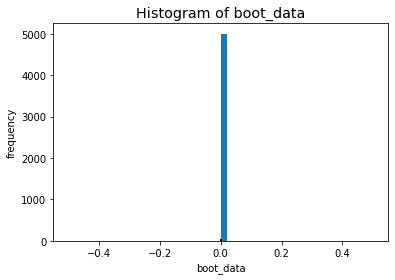

,0
0.025,0.0
0.975,0.0


In [11]:
get_bootstrap(CR_active_A['is_converted'], CR_active_B['is_converted'], statistic=np.median, boot_it=5000)['ci']

100%|██████████| 3000/3000 [00:21<00:00, 141.19it/s]


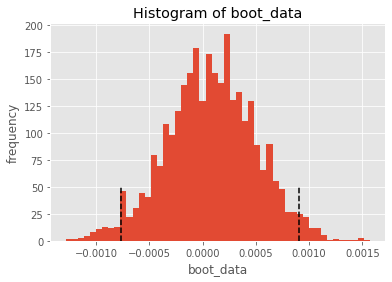

,0
0.025,-0.000769
0.975,0.000903


In [12]:
get_bootstrap(CR_active_A['is_converted'], CR_active_B['is_converted'], statistic=np.mean, boot_it=3000)['ci']

In [ ]:
# Т.к. ноль попадает в доверительный интервал, мы можем говорить о том, что 
# статистически значимого различия в конверсиях групп А и Б нет

In [ ]:
# теперь проведем тест для всех пользователей, что произвели оплату во время эксперимента

In [53]:
payed_users = groups_df.merge(right=cheks_df, how='inner', left_on='id', right_on='student_id')

In [57]:
# посмотрим, какое распределение по группам у плативших, но не зарегестрированных в качестве 
# активных пользователей
payed_users['grp'].value_counts()['B'] - merged_checks['grp'].value_counts()['B']

120

In [58]:
payed_users['grp'].value_counts()['A'] - merged_checks['grp'].value_counts()['A']

29

In [ ]:
# как видно, диспропорция (пользователей группы Б примерно в 4 раза больше, чем группы А)
# сохраняется и здесь

Text(0.5, 1.0, 'payable')

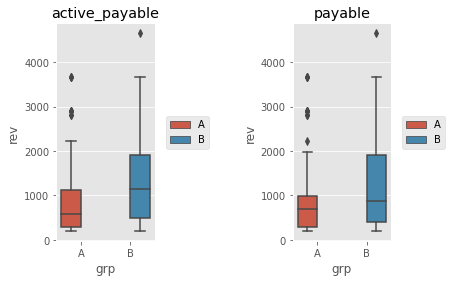

In [73]:
# посмотрим на данные и наличие выбросов в них для платящих пользователей
# и сравним с данными для активных платящих пользователей
plt.subplot(1, 3, 1)
sns.boxplot(data=merged_checks, hue='grp', y='rev', x='grp')
plt.legend(loc='center right', bbox_to_anchor=(1.6, 0.5))
plt.title(label='active_payable')
plt.subplot(1, 3, 3)
sns.boxplot(data=payed_users, hue='grp', y='rev', x='grp', hue_order=['A', 'B'], order=['A', 'B'])
plt.legend(loc='center right', bbox_to_anchor=(1.6, 0.5))
plt.title(label='payable')

In [ ]:
# как видно из сравнения данных для платящих и активных платящих пользователей
# у активных платящих пользователей группы А "усы" боксплота выше, при этом значение 2 квартиля ниже, а
# 3 выше, чем у платящих пользователей
# выбросами считаются значения выше примерно 2300, когда для платящих пользователей значения выше 
# примерно 2000. 
# для группы Б платящих пользователей значение второго квартиля ниже, чем для активных платящих
# той же группы.
# В целом же можно сделать вывод, что у активных платящих пользователей группы А боксплот выше, что значит - 
# выше средний чек. 

In [99]:
payed_users = groups_df.merge(right=cheks_df, how='outer', left_on='id', right_on='student_id')
payed_users['is_converted'] = pd.cut(x=payed_users['rev'], bins=[-1, 0, max(CR_active['rev'])], labels=[0, 1]).fillna(0)
payed_users['is_converted'] = payed_users['is_converted'].astype('Int32')
payed_A = payed_users[(payed_users['grp'] == 'A') & (payed_users['rev'] > 0)]
payed_B = payed_users[(payed_users['grp'] == 'B') & (payed_users['rev'] > 0)]

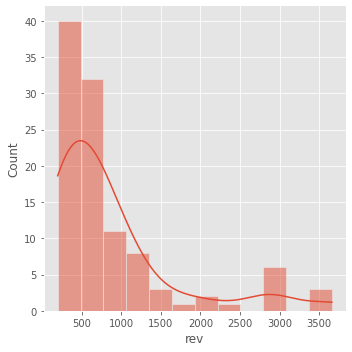

In [83]:
sns.displot(x=payed_A['rev'], kde=True)  # распределение данных в группе А 

In [82]:
# Посмотрим на соответствие данных в выборке для группы Б нормальному распределению
st.shapiro(x=payed_A['rev'])

ShapiroResult(statistic=0.7196124196052551, pvalue=5.321687643507211e-13)

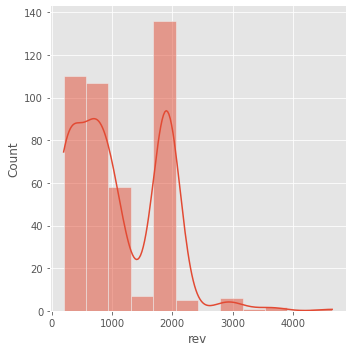

In [84]:
sns.displot(x=payed_B['rev'], kde=True)  # распределение данных в группе Б

In [85]:
st.shapiro(x=payed_B['rev'])

ShapiroResult(statistic=0.867313027381897, pvalue=9.542798088039443e-19)

In [ ]:
# распределение для средних чеков групп А и Б платящих пользователей ненормально,
# поэтому воспользуемся непараметрическим тестом Манна-Уитни

In [ ]:
# избавимся от выбросов

In [114]:
payed_A = payed_A[payed_A['rev'] <= 2000]
payed_B = payed_B[payed_B['rev'] <= 4000]

In [115]:
# используем тест Манна-Уитни
st.mannwhitneyu(payed_A['rev'], payed_B['rev'])

MannwhitneyuResult(statistic=13584.0, pvalue=4.73870939389106e-08)

In [ ]:
# тест Манна-Уитни показал, что есть статистически значимое различие между средним чеком
# для группы А и Б платящих пользователей

In [ ]:
# теперь посмотрим на конверсию в покупку 

In [117]:
CR_payable_A = payed_users[payed_users['grp'] == 'A']
CR_payable_B = payed_users[payed_users['grp'] == 'B']

In [1]:
get_bootstrap(CR_payable_A['is_converted'], CR_payable_B['is_converted'], statistic=np.mean, boot_it=3000)['ci']

NameError: name 'get_bootstrap' is not defined

In [ ]:
# по результатам бутстрапа статистически значимого различия в конверсии для групп А и Б
# платящих пользователей нет (0 попадает в доверительный интервал)

In [ ]:
# исходя из результатов АБ-теста можно сделать вывод о том, что средний чек группы Б статистически
# значимо отличается от среднего чека группы А, при этом он выше, чем у последней.
# Конверсия двух групп статистически значимо не различается. На основе вышесказанного можно 
# предложить использовать новый дизайн. 

In [ ]:
########################################################################################################################

In [ ]:
#                                                 Задание 2.1

In [2]:
connection_default = {'host': 'http://clickhouse.beslan.pro:8080',  # задаем параметры подключения к базе данных 
                      'database': 'default',
                      'user': 'student', 
                      'password': 'dpo_python_2020'
                      }

In [5]:
query_good_st = '''SELECT COUNT(DISTINCT st_id) as good_st
FROM 
    (
    SELECT  st_id, 
            formatDateTime(timest, '%d %H') as solving_day_hour,
            COUNT(correct) as right_pea
    FROM default.peas
    WHERE   (correct = 1) AND                                       
            (formatDateTime(timest, '%Y %m') = '2020 03')
    GROUP BY st_id, solving_day_hour
    )
WHERE right_pea >= 20 
'''
good_st_df = ph.read_clickhouse(query=query_good_st, connection=connection_default) 
good_st_df.head(10)

,good_st
0,0


In [32]:
#                                                 Задание 2.2

In [33]:
# в таблице "studs" пользователю с одним и тем же id присвоено несколько значений old или/и new, 
# что неправильно с точки зрения создания самих таблиц (есть id, но при этом строки не являются уникальными), 
# а также неверно с точки зрения логики проведения АБ-эксперимента - одного пользователя в рамках одного 
# эксперимента почему-то относят к двум разным группам, либо не содержится информации о разграничении двух разных 
# экспериментов. В данном случае, чтобы корректно соединить таблицы, стоит создать в них столбцы с числовыми значениями 
# от 1 до числа, равного кол-ву строк таблицы (ключ). Альтернативным вариантом для решения поставленной задачи 
# является использование конструкции WITH. 

In [124]:
# посмотрим на данные таблицы studs, из них видно, что строки с id студента не уникальны 
query_studs = '''SELECT * FROM default.studs'''
q_studs_df = ph.read_clickhouse(query=query_studs, connection=connection_default) 
q_studs_df.head(15)

,st_id,test_grp
0,1EYY37,old
1,1N8MTZ,new
2,1N8MTZ,new
3,1N8MTZ,new
4,1N8MTZ,new
5,1N8MTZ,new
6,1N8MTZ,new
7,1N8MTZ,old
8,1N8MTZ,old
9,1N8MTZ,old


In [35]:
# В трех таблицах даны данные лишь об активных (платящих) пользователях, в этом легко убедиться - 
# число уникальных пользователей в таблицах по-отдельности совпадает с числом уникальных пользователей 
# при соединении таблиц типом INNER JOIN.
checks_peas = ph.read_clickhouse('''SELECT  count(DISTINCT(st_id)) as students
FROM (SELECT * 
    FROM default.peas as A
    JOIN default.final_project_check AS B
    ON A.st_id = B.st_id
)
''', connection=connection_default)
checks_peas

,students
0,30


In [36]:
# При этом число уникальных id аналогичное и для таблиц final_project_check, peas, studs
# Это уже позволяет говорить нам о том, что CR в покупку = CR активного пользователя в покупку = 1, ARPU = ARPAU, 
# т.к. имеется информация лишь об активных платящих пользователях
checks = ph.read_clickhouse('''SELECT uniqExact(st_id) as students FROM default.final_project_check''',
                            connection=connection_default)
checks

,students
0,30


In [37]:
peas = ph.read_clickhouse('''SELECT uniqExact(st_id) as students FROM default.peas''', connection=connection_default)
peas

,students
0,30


In [38]:
studs_peas = ph.read_clickhouse('''SELECT  count(DISTINCT(st_id)) as students
FROM (SELECT * 
    FROM default.peas as A
    JOIN default.studs AS B
    ON A.st_id = B.st_id
)
''', connection=connection_default)
studs_peas

,students
0,30


In [3]:
metrics = '''WITH  
(
    SELECT uniqExact(check_st_id) as payable_math 
    FROM
    (
        SELECT * 
        FROM
            (
                SELECT  st_id as check_st_id, 
                        subject, 
                        money,
                        row_number() OVER(ORDER BY check_st_id) as fw
                FROM default.final_project_check
            ) as check
        JOIN (
                SELECT  st_id,
                    test_grp,
                    row_number() OVER(ORDER BY st_id) as sw 
                FROM default.studs
            ) as studs
        ON  check.check_st_id = studs.st_id AND fw = sw
    ) 
    WHERE subject = 'Math'
    
) as b


SELECT  a.test_grp,
        sum(a.money) / uniqExact(a.st_id) as ARPU,
        sum(a.money) / uniqExact(a.peas.st_id) as ARPAU,
        uniqExact(a.check_st_id) / uniqExact(a.st_id) as CR_to_buy,
        uniqExact(a.peas.st_id) / uniqExact(a.st_id) as CR_active_to_buy,
        b / uniqExact(a.st_id) as CR_math 
        
FROM  (
    SELECT * 
    FROM
    (
        SELECT * 
        FROM
            (
                SELECT  st_id as check_st_id, 
                        subject, 
                        money,
                        row_number() OVER(ORDER BY check_st_id) as fw
                FROM default.final_project_check
            ) as check
        JOIN (
                SELECT  st_id,
                    test_grp,
                    row_number() OVER(ORDER BY st_id) as sw 
                FROM default.studs
                    ) as studs
        ON  check.check_st_id = studs.st_id AND fw = sw
        ) as c_s
        JOIN   (
                SELECT  st_id,
                        subject,
                        row_number() OVER(ORDER BY st_id) as pw 
                FROM default.peas       
                ) as peas
        ON c_s.st_id = peas.st_id and fw = pw 
) as a

GROUP BY test_grp
'''

metriq_df = ph.read_clickhouse(query=metrics, connection=connection_default)
metriq_df

,test_grp,ARPU,ARPAU,CR_to_buy,CR_active_to_buy,CR_math
0,new,59482.758621,59482.758621,1.0,1.0,0.724138
1,old,58965.517241,58965.517241,1.0,1.0,0.724138


In [40]:
#                                               Задание 3

In [3]:
# путь дополнительного файла
path_to_additional = '/home/jupyter-i.gorodnichev-15/files_for_project/Проект_2_group_add.csv' 

In [27]:
def addition(path):
    """"Считывает дополнительный файл и считает метрики 
    
    Вводимый аргумент
    path -- путь к датафрейму 
    
    Используемые переменные 
    df -- подгружаемый датафрейм 
    col_names -- список с названиями колонок из подгружаемого файла
    added_df -- датафрейм после присоединения подгружаемого датафрейма
    users -- количество строк added_df, оно равно общему числу пользователей
    active_payable_users -- датафрейм с данными об активных платящих пользователях
    active -- датафрейм с данными об активных пользователях 
    payable -- датафрейм с данными о платящих пользователях 
    ARPU, ARPAU, CR_to_buy, CR_active_to_buy -- считаемые метрики 
    """
    df = pd.read_csv(path_to_additional, sep=',', encoding='utf-8')
    
    col_names = df.columns.tolist()
    for i in range(0, len(col_names)):
        if col_names[i].find('id') > -1:
            df.rename(columns={col_names[i]: 'id'})
        if (col_names[i].find('grp') > -1) or (col_names[i].find('group') > -1):
            df.rename(columns={col_names[i]: 'grp'})
    added_df = pd.concat([groups_df, df]).reset_index(drop=True) 
    
    users = added_df.shape[0]   
    
    active_payable_users = info_df.merge(right=cheks_df, on='student_id', how='inner')
        .merge(how='left', right=added_df, left_on='student_id', right_on='id')
    active = info_df
    payable = cheks_df
    active = active.merge(how='left', right=added_df, left_on='student_id', right_on='id')  
    payable = payable.merge(how='left', right=added_df, left_on='student_id', right_on='id')
    
    active_payable_users['CR_active_to_buy'] = 1 / users  
    payable['CR_to_buy'] = 1 / users
    payable['ARPU'] = payable['rev'] / users
    payable['ARPAU'] = payable['rev'] / active.shape[0]
    
    ARPU = payable['ARPU'].sum()  
    ARPAU = payable['ARPAU'].sum()
    CR_to_buy = payable['CR_to_buy'].sum()
    CR_active_to_buy = active_payable_users['CR_active_to_buy'].sum()
    
    return f'ARPU = {ARPU}, ARPAU = {ARPAU}, CR_to_buy = {CR_to_buy}, CR_active_to_buy = {CR_active_to_buy}'

In [45]:
addition(path_to_additional)

'ARPU = 7.687808458485304, ARPAU = 68.7358834192543, CR_to_buy = 0.007254344561252951, CR_active_to_buy = 0.00525638275048273'

In [26]:
# данная функция во многом будет копировать предыдущую
def plots():
    """"Считывает дополнительный файл, считает метрики и строит на их основе графики
 
    Используемые переменные 
    df -- подгружаемый датафрейм 
    col_names -- список с названиями колонок из подгружаемого файла
    added_df -- датафрейм после присоединения подгружаемого датафрейма
    users -- количество строк added_df, оно равно общему числу пользователей
    active_payable_users -- датафрейм с данными об активных платящих пользователях
    active -- датафрейм с данными об активных пользователях 
    payable -- датафрейм с данными о платящих пользователях 
    ARPU, ARPAU, CR_to_buy, CR_active_to_buy -- считаемые метрики 
    """
    df = pd.read_csv(path_to_additional, sep=',', encoding='utf-8') 
    
    col_names = df.columns.tolist()
    for i in range(0, len(col_names)):
        if col_names[i].find('id') > -1:
            df.rename(columns={col_names[i]: 'id'})
        if (col_names[i].find('grp') > -1) or (col_names[i].find('group') > -1):
            df.rename(columns={col_names[i]: 'grp'})
            
    added_df = pd.concat([groups_df, df]).reset_index(drop=True)   
   
    users = added_df.shape[0] 
    
    active_payable_users = info_df.merge(right=cheks_df, on='student_id', how='inner')
        .merge(how='left', right=added_df, left_on='student_id', right_on='id')
    active = info_df
    payable = cheks_df
    active = active.merge(how='left', right=added_df, left_on='student_id', right_on='id')  
    payable = payable.merge(how='left', right=added_df, left_on='student_id', right_on='id')
    
    active_payable_users['CR_active_to_buy'] = 1 / users  
    payable['CR_to_buy'] = 1 / users
    payable['ARPU'] = payable['rev'] / users
    payable['ARPAU'] = payable['rev'] / active.shape[0]
    
    payable = payable.rename(columns={'grp': 'group'})
    active_payable_users = active_payable_users.rename(columns={'grp': 'group'})
     
    plt.subplot(1, 3, 1)
    sns.barplot(data=payable, x='group', y='ARPU', estimator=sum)
    plt.subplot(1, 3, 3)
    sns.barplot(data=payable, x='group', y='ARPAU', estimator=sum)
    plt.show()
    plt.subplot(1, 3, 1)
    sns.barplot(data=payable, x='group', y='CR_to_buy', estimator=sum)
    plt.subplot(1, 3, 3)
    sns.barplot(data=active_payable_users, x='group', y='CR_active_to_buy', estimator=sum)
    plt.show()

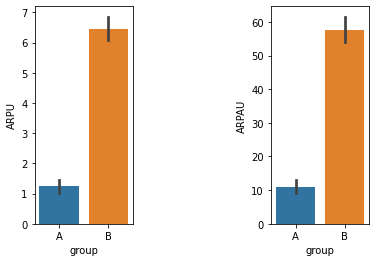

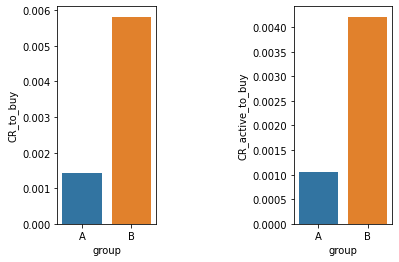

In [46]:
plots()

In [65]:
df = pd.read_csv(path_to_additional, sep=',', encoding='utf-8')  # считываем дополнительный файл
added_df = pd.concat([groups_df, df]).reset_index(drop=True)  # соединяем счиатнный файл с датафреймом,
added_df['grp'].value_counts()

B    59883
A    14693
Name: grp, dtype: int64

In [66]:
active_payable_users = info_df.merge(right=cheks_df, on='student_id', how='inner').
    merge(how='left', right=added_df, left_on='student_id', right_on='id')
active = info_df
payable = cheks_df
active = active.merge(how='left', right=added_df, left_on='student_id', right_on='id')  # при объединении получаем 
# информацию о разделении пользователей на группы
payable = payable.merge(how='left', right=added_df, left_on='student_id', right_on='id')
active['grp'].value_counts()

B    6803
A    1538
Name: grp, dtype: int64

In [67]:
payable['grp'].value_counts()

B    434
A    107
Name: grp, dtype: int64

In [68]:
active_payable_users['grp'].value_counts()

B    314
A     78
Name: grp, dtype: int64

In [ ]:
# исходя из графиков, что показаны выше, видно, что метрики для группы Б выше, чем для А. Однако также заметно, 
# что количество собранной для группы А информации почти в 4 раза меньше, чем для группы Б, даже
# после подгрузки файла с дополнительной информацией.
# Большее колчество пользователей из другой группы, и, соответственно, информации об их платежах завышает показатели 
# метрик при рассмотрении их относительно разных групп. Такая диспропорция в делении пользователей на группы могла 
# повлиять также на результаты АБ-теста, сделав выводы о его результатах неверными. 